# Homework 3

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.

In the 2023 course offering, pick either 1. or 2., and then 3.

**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [6]:
# Import the Obspy modules that will be useful to download seismic data
!pip install obspy
from obspy import read, UTCDateTime, Stream
from obspy.clients.fdsn import Client


**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [8]:
# answer below
client = Client("IRIS")
Tstart = UTCDateTime("2015-01-01T00:00:00")
Tend = UTCDateTime("2015-03-31T23:59:59")
st = client.get_waveforms(network="XH", station="DR01", location="--", channel="LHN", starttime=Tstart, endtime=Tend)
# st.remove_response()  # <-- REMOVE or comment out this line!
tr = st[0]


In [10]:
# how many days did we download?
dt= Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days

print("Number of days downloaded:")
print(Ndays)

Number of days downloaded:
89


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [11]:
# answer below
from scipy.signal import butter, buttord, sosfiltfilt, freqs

fs = tr.stats.sampling_rate
data = tr.data

# Lowpass filter below 0.01 Hz
sos_low = butter(4, 0.01, btype='low', fs=fs, output='sos')
data_low = sosfiltfilt(sos_low, data)

# Bandpass filter 0.01-0.1 Hz
sos_band = butter(4, [0.01, 0.1], btype='band', fs=fs, output='sos')
data_band = sosfiltfilt(sos_band, data)

# Highpass filter above 0.1 Hz
sos_high = butter(4, 0.1, btype='high', fs=fs, output='sos')
data_high = sosfiltfilt(sos_high, data)


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

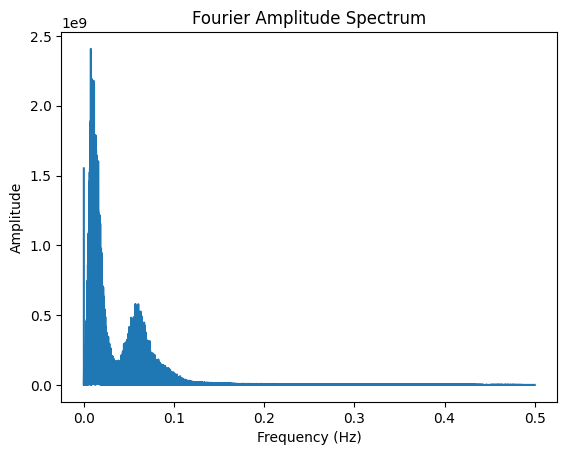

In [12]:
# import FFT modules
import numpy as np
from scipy.fft import fft, fftfreq

n = len(data)
dt = tr.stats.delta
freqs = fftfreq(n, dt)
fft_vals = np.abs(fft(data))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(freqs[:n//2], fft_vals[:n//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Amplitude Spectrum")
plt.show()

Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

In [13]:

# answer below
from numpy import random
from scipy.fftpack import ifft, ifftshift

amp = np.abs(fft(data))
phase = np.exp(1j * 2 * np.pi * random.rand(len(amp)))
synth_noise = np.real(ifft(amp * phase))


**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

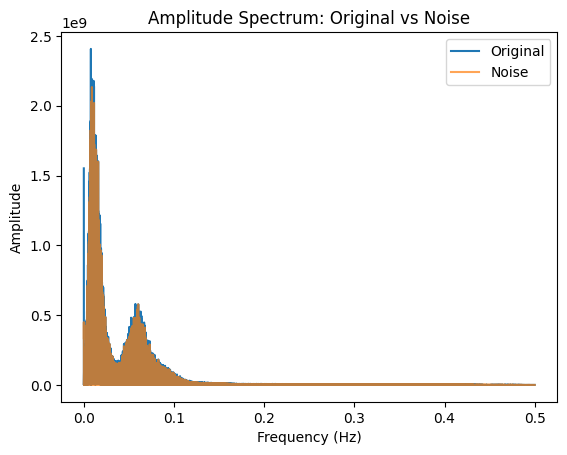

In [14]:
# answer below
fft_noise = np.abs(fft(synth_noise))
plt.figure()
plt.plot(freqs[:n//2], fft_vals[:n//2], label="Original")
plt.plot(freqs[:n//2], fft_noise[:n//2], label="Noise", alpha=0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Amplitude Spectrum: Original vs Noise")
plt.show()

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

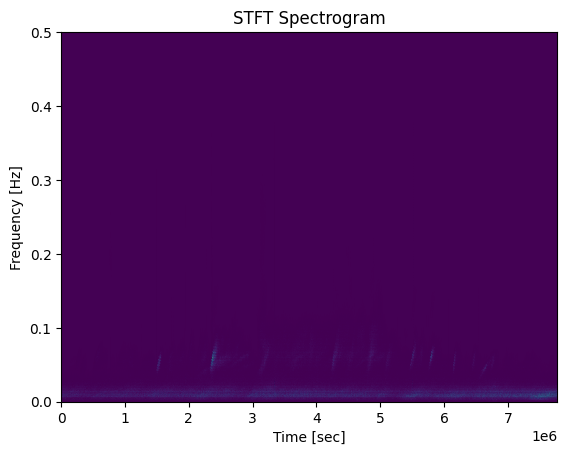

In [15]:
# answer below
from scipy.signal import stft

f, t, Zxx = stft(data, fs=fs, nperseg=1024)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('STFT Spectrogram')
plt.show()

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [20]:
# answer below
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os

csv_path = "./TEC/ioncorr_samo_015_2022_tonga.csv"
if not os.path.exists(csv_path):
    print(f"File not found: {csv_path}")
    print("Please check that the file exists at the specified path. If not, download or move it there.")
else:
    df = pd.read_csv(csv_path)
    df['datetime'] = pd.to_datetime(df['time'], unit='s')
    sat_cols = [col for col in df.columns if 'variometric_derived_TEC_filtered' in col]
    plt.figure(figsize=(10, 6))
    for col in sat_cols:
        plt.plot(df['datetime'], df[col], label=col)
    plt.xlabel("Time")
    plt.ylabel("Filtered vTEC (TECU)")
    plt.title("Filtered vTEC for each satellite")
    plt.legend()
    plt.show()

File not found: ./TEC/ioncorr_samo_015_2022_tonga.csv
Please check that the file exists at the specified path. If not, download or move it there.


## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [21]:
# answer below
filename = "./TEC/ioncorr_samo_015_2022_tonga.csv"
station = filename.split("_")[1]
print("Station name:", station)

Station name: samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

In [22]:
# answer below
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os

csv_path = "./TEC/ioncorr_samo_015_2022_tonga.csv"
if not os.path.exists(csv_path):
    print(f"File not found: {csv_path}")
    print("Please check that the file exists at the specified path. If not, download or move it there.")
else:
    df = pd.read_csv(csv_path)
    df['datetime'] = pd.to_datetime(df['time'], unit='s')
    sat_cols = [col for col in df.columns if 'variometric_derived_TEC_filtered' in col]
    plt.figure(figsize=(10, 6))
    for col in sat_cols:
        plt.plot(df['datetime'], df[col], label=col)
    plt.xlabel("Time")
    plt.ylabel("Filtered vTEC (TECU)")
    plt.title("Filtered vTEC for each satellite")
    plt.legend()
    plt.show()

File not found: ./TEC/ioncorr_samo_015_2022_tonga.csv
Please check that the file exists at the specified path. If not, download or move it there.


You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. Select the time series of interest and plot the time series. What can you tell about the time-frequency characteristic of these disturbances?

In [23]:
# answer below
import scipy.signal as signal

sat_col = sat_cols[0]  # pick one satellite
tec = df[sat_col].values
plt.plot(df['datetime'], tec)
plt.xlabel("Time")
plt.ylabel("Filtered vTEC (TECU)")
plt.title("TEC for one satellite")
plt.show()

NameError: name 'sat_cols' is not defined

Calculate the sampling frequency by taking the time difference between two samples.

In [ ]:
#answer below
dt = (df['datetime'][1] - df['datetime'][0]).total_seconds()
fs = 1.0 / dt
print("Sampling frequency (Hz):", fs)

Perform the wavelet transform. You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

In [ ]:
import scipy.signal as signal
# use the number of scales
w = np.arange(1, 50)

# answer below
coef, freqs = signal.cwt(tec, signal.morlet2, w, w=6), w
plt.imshow(np.abs(coef), aspect='auto', extent=[0, len(tec)*dt/3600, w[-1], w[0]])
plt.xlabel("Time (hours)")
plt.ylabel("Scale")
plt.title("Wavelet Transform (Morlet)")
plt.colorbar(label="Amplitude")
plt.show()

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

(answer below)

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc``, ``NCM_SpatialGrid.nc``, and ``NCM_AuxData.nc``.

We first download the data from our Dropbox folder


In [ ]:
import wget
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"



In the following we will prepare our data. Read the DataSets using the python NetCDF4 library.

In [ ]:
# ansert below
import netCDF4 as nc
ds1 = nc.Dataset(file1)
ds2 = nc.Dataset(file2)
ds3 = nc.Dataset(file3)


**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``, which are data sets from the NC files. Use the matplotlib function``contourf``, and the variables for lat long ``x`` and ``y`` . You can use the argument ``levels`` to the contourf funxtion to split the color map into discrete contour levels, and the transparency argument ``alpha`` to be less than 1.

In [ ]:
# answer below
plt.figure()
plt.contourf(x, y, WT, levels=20, alpha=0.7)
plt.colorbar(label='Water Table')
plt.title('Water Table')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.contourf(x, y, elevation, levels=20, alpha=0.7)
plt.colorbar(label='Elevation')
plt.title('Elevation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# plot below
plt.figure()
plt.contourf(x, y, WT, levels=20, alpha=0.7)
plt.colorbar(label='Water Table')
plt.title('Water Table')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**b. Perform and plot the 2D Fourier transforms (4 points)**

In [ ]:
# answer below
from scipy.fftpack import fft2, fftfreq, fftshift
import matplotlib.cm as cm

WT_fft = fftshift(fft2(WT))
elev_fft = fftshift(fft2(elevation))

plt.figure()
plt.imshow(np.log(np.abs(WT_fft)), cmap=cm.viridis)
plt.title("2D FFT of Water Table")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log(np.abs(elev_fft)), cmap=cm.viridis)
plt.title("2D FFT of Elevation")
plt.colorbar()
plt.show()

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

(answer below)

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [ ]:
# solution
from scipy.ndimage import gaussian_filter

WT_lowpass = gaussian_filter(WT, sigma=5)
plt.figure()
plt.contourf(x, y, WT_lowpass, levels=20, alpha=0.7)
plt.colorbar(label='Lowpass Water Table')
plt.title('Lowpass Filtered Water Table')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [ ]:
# Sort the Fourier coefficients
flat = np.abs(WT_fft).flatten()
idx = np.argsort(flat)[::-1]

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

In [ ]:

#snwer below
percentages = np.arange(0.01, 0.11, 0.01)
n_total = WT_fft.size

for p in percentages:
    WT_fft_compressed = np.zeros_like(WT_fft)
    n_keep = int(p * n_total)
    inds = idx[:n_keep]
    WT_fft_compressed.flat[inds] = WT_fft.flat[inds]
    WT_recon = np.real(np.fft.ifft2(np.fft.ifftshift(WT_fft_compressed)))
    plt.figure()
    plt.imshow(WT_recon, cmap='viridis')
    plt.title(f"Reconstructed WT with {int(p*100)}% coefficients")
    plt.colorbar()
    plt.show()
    time.sleep(0.5)
    plt.close()

Now we will compare the original 2D data set with the Fourier compressed data


In [ ]:
# answer below
WT_fft_10 = np.zeros_like(WT_fft)
WT_fft_10.flat[idx[:int(0.1 * n_total)]] = WT_fft.flat[idx[:int(0.1 * n_total)]]
WT_recon_10 = np.real(np.fft.ifft2(np.fft.ifftshift(WT_fft_10)))

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(WT, cmap='viridis')
plt.title("Original WT")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(WT_recon_10, cmap='viridis')
plt.title("10% Fourier Coefficients")
plt.colorbar()
plt.show()